<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Multinomial Logistic Regression Lab

---

## Introduction

In this lab you will practice performing multinomial logistic regression while also applying cross-validation and regularisation on a popular sample dataset about bikesharing. You'll be predicting the season according to the given weather data.

---

## Aim

1. Structure a new dataframe with features, create dummy features with pd.get_dummies(), and join dummies to the data frame
2. Use the bikeshare dataset to create cross-validated multinomial logistic regression models.
3. Build 3 different models: default logistic regression, logistic regression with l1-penalty, and logistic regression with l2-penalty. Report on the accuracy reached in each case.

--- 
## Additional Resources

- [The bikeshare dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#)
- [Cross-validation with sklearn](http://scikit-learn.org/stable/modules/cross_validation.html)
- [Logistic regression with sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
 
---

## 1. Load the libraries and the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score

In [3]:
path = '../../../../../resource-datasets/bikeshare/bikeshare.csv'
bikeshare = pd.read_csv(path)

In [4]:
bikeshare.shape

(17379, 17)

In [5]:
bikeshare.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

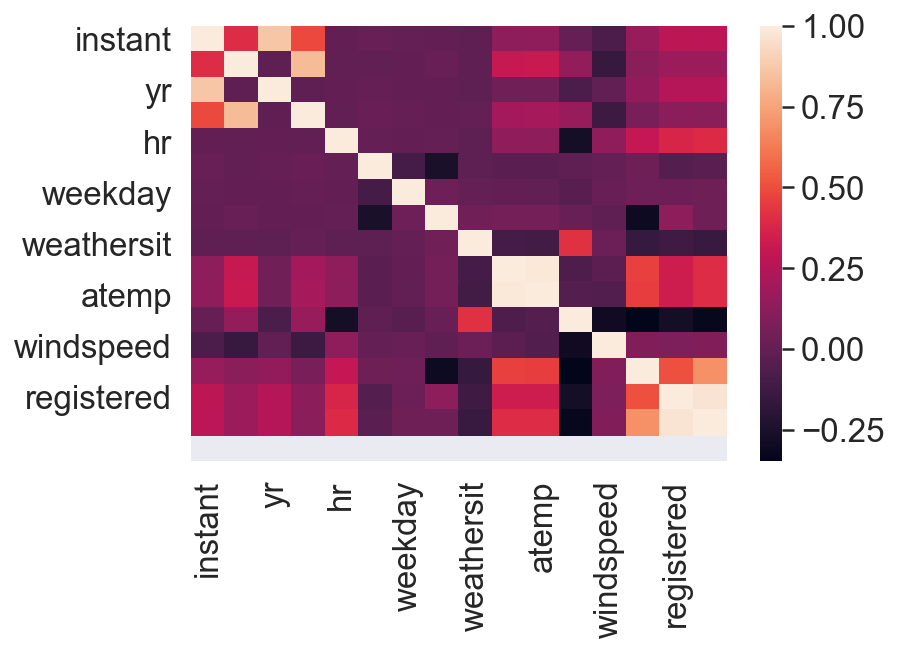

In [6]:
sns.heatmap(bikeshare.corr())
plt.ylim(bikeshare.shape[1], 0)
plt.show()

In [7]:
bikeshare.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [8]:
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [9]:
bikeshare.groupby('season')['mnth'].apply(pd.unique)

season
1      [1, 2, 3, 12]
2       [3, 4, 5, 6]
3       [6, 7, 8, 9]
4    [9, 10, 11, 12]
Name: mnth, dtype: object

In [10]:
bikeshare.groupby('season')['mnth'].apply(pd.value_counts)

season    
1       1     1429
        2     1341
        3      949
        12     523
2       5     1488
        4     1437
        6      960
        3      524
3       7     1488
        8     1475
        9     1053
        6      480
4       10    1451
        11    1437
        12     960
        9      384
Name: mnth, dtype: int64

In [11]:
bikeshare[bikeshare.season==1].mnth.value_counts()

1     1429
2     1341
3      949
12     523
Name: mnth, dtype: int64

In [12]:
bikeshare.season.value_counts()

3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64

In [13]:
bikeshare.season.value_counts(normalize=True)

3    0.258703
2    0.253697
1    0.244088
4    0.243512
Name: season, dtype: float64

In [14]:
seasons = bikeshare.season.unique()

In [15]:
bikeshare.weathersit.unique()

array([1, 2, 3, 4])

In [16]:
pd.get_dummies(bikeshare, columns=['weathersit'],
               prefix='weather', drop_first=True).head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,weather_2,weather_3,weather_4
0,1,2011-01-01,1,0,1,0,0,6,0,0.24,0.2879,0.81,0.0,3,13,16,0,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,0.22,0.2727,0.80,0.0,8,32,40,0,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,0.22,0.2727,0.80,0.0,5,27,32,0,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,0.24,0.2879,0.75,0.0,3,10,13,0,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,0.24,0.2879,0.75,0.0,0,1,1,0,0,0


In [17]:
weather = pd.get_dummies(bikeshare.weathersit,
                         prefix='weather', drop_first=True)
weather.head()

,weather_2,weather_3,weather_4
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


### 2. Join the bikeshare dataframe and the weather dataframe

In [18]:
bikeshare = bikeshare.join(weather)

### 3. Choose the weatherrelated features as predictors and the season as response

In [19]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
feature_cols = ['temp', 'hum', 'weather_2',
                'weather_3', 'weather_4', 'atemp', 'windspeed']
X = bikeshare[feature_cols]
y = bikeshare.season

In [20]:
X.head()

,temp,hum,weather_2,weather_3,weather_4,atemp,windspeed
0,0.24,0.81,0,0,0,0.2879,0.0
1,0.22,0.80,0,0,0,0.2727,0.0
2,0.22,0.80,0,0,0,0.2727,0.0
3,0.24,0.75,0,0,0,0.2879,0.0
4,0.24,0.75,0,0,0,0.2879,0.0


### 4. Perform a train-test split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=1)

### 5. Rescale the data set.

Use the standard scaler with `fit_transform` on the training set and with transform on the `test set`. Why would you consider doing it in this way?

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(
    X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(
    X_test), columns=X_test.columns, index=X_test.index)

### 6. Fit a logistic regression model on the training set. Evaluate it and get the predictions on the test set.

In [25]:
model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train, y_train)
yhat_test = model.predict(X_test)
model.score(X_test, y_test)

0.5840046029919448

### 7. Report the accuracy, the confusion matrix and the classification report on the test set

In [26]:
pd.DataFrame(confusion_matrix(y_test, yhat_test, labels=seasons),
             index=seasons, columns=seasons)

,1,2,3,4
1,971,105,8,189
2,208,425,443,247
3,0,118,1195,36
4,427,269,119,454


In [27]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           1       0.60      0.76      0.67      1273
           2       0.46      0.32      0.38      1323
           3       0.68      0.89      0.77      1349
           4       0.49      0.36      0.41      1269

    accuracy                           0.58      5214
   macro avg       0.56      0.58      0.56      5214
weighted avg       0.56      0.58      0.56      5214



### 8. Use LogisticRegressionCV to fit a range of l1 penalty values to the training set. 

Hint: l1-penalty requires setting the solver to liblinear.

In [28]:
np.logspace(-4, 4, 10)

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [29]:
10**np.linspace(-4, 4, 10)

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [30]:
model_l1 = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear',
                                multi_class='ovr', cv=5, random_state=1, 
                                max_iter=1000, n_jobs=2, verbose=1)
model_l1.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  6.4min finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='ovr', n_jobs=2, penalty='l1',
                     random_state=1, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=1)

In [31]:
model_l1.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [32]:
# best regularization strenghts in one-vs-one fits
model_l1.C_

array([3.59381366e-01, 1.00000000e-04, 4.64158883e-02, 1.00000000e-04])

In [33]:
model_l1.scores_

{1: array([[0.75605749, 0.83326489, 0.84229979, 0.84681725, 0.84435318,
         0.84271047, 0.84312115, 0.84353183, 0.84271047, 0.84271047],
        [0.75595727, 0.82046015, 0.83607231, 0.83566146, 0.83566146,
         0.83319638, 0.83319638, 0.83319638, 0.83319638, 0.83319638],
        [0.75585697, 0.83888204, 0.83847102, 0.84093711, 0.84422524,
         0.84175915, 0.84175915, 0.84258118, 0.84258118, 0.84258118],
        [0.75575658, 0.84333882, 0.84991776, 0.85320724, 0.85115132,
         0.84991776, 0.84950658, 0.84909539, 0.85032895, 0.84950658],
        [0.75606746, 0.83957219, 0.84491979, 0.84697655, 0.84985603,
         0.85109009, 0.84985603, 0.84286302, 0.84903332, 0.84985603]]),
 2: array([[0.74620123, 0.74620123, 0.74620123, 0.74537988, 0.74045175,
         0.74045175, 0.74045175, 0.74045175, 0.74045175, 0.74045175],
        [0.74650781, 0.74650781, 0.74650781, 0.74609696, 0.74239934,
         0.74157765, 0.7411668 , 0.7411668 , 0.7411668 , 0.7411668 ],
        [0.74640362

In [34]:
# best accuracy scores in one-vs-one fits
{i: round(scores.mean(), 3) for i, scores in model_l1.scores_.items()}

{1: 0.834, 2: 0.743, 3: 0.86, 4: 0.751}

In [35]:
# the best intercepts
model_l1.intercept_

array([-2.2310975 ,  0.        , -2.77946508,  0.        ])

In [36]:
# the best coefficients
model_l1.coef_

array([[-3.60885029, -0.45651344,  0.18895113,  0.16575857,  0.0305845 ,
         1.3063834 ,  0.29200269],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 3.21197469,  0.68065722, -0.15972996, -0.08526745,  0.        ,
         0.        , -0.21111248],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [37]:
# the predicted probabilities
model_l1.predict_proba(X_test)[:10]

array([[3.65483047e-02, 3.86930017e-01, 1.89591662e-01, 3.86930017e-01],
       [2.59891088e-03, 2.66600761e-01, 4.64199567e-01, 2.66600761e-01],
       [5.25348683e-03, 3.04041931e-01, 3.86662650e-01, 3.04041931e-01],
       [7.05576039e-02, 4.40885213e-01, 4.76719698e-02, 4.40885213e-01],
       [5.54188556e-03, 3.01917552e-01, 3.90623010e-01, 3.01917552e-01],
       [3.67960493e-01, 3.15570818e-01, 8.97870923e-04, 3.15570818e-01],
       [1.31350021e-01, 4.17664809e-01, 3.33203606e-02, 4.17664809e-01],
       [4.12764166e-01, 2.93433694e-01, 3.68446869e-04, 2.93433694e-01],
       [9.86950376e-03, 3.46951628e-01, 2.96227239e-01, 3.46951628e-01],
       [1.00176862e-01, 4.30874711e-01, 3.80737166e-02, 4.30874711e-01]])

In [38]:
# test score
yhat_test_l1 = model_l1.predict(X_test)
print(accuracy_score(y_test, yhat_test_l1))

0.5360567702339855


In [39]:
# check values for all scores (has for each of the four classes shape #cv steps times #models)
list(model_l1.scores_.values())[1].shape

(5, 10)

In [40]:
# predicted labels
yhat_test_l1

array([2, 3, 3, ..., 2, 3, 2])

The different sets of coefficients stem from considering the binary problem of predicting being in one or any of the other three classes.

For example, if we only predict being in class 1 or not, we can check that we get the same results.

In [41]:
from sklearn.preprocessing import label_binarize

# binarize the outcome variable
y_train_bin = label_binarize(y_train, model_l1.classes_)
y_test_bin = label_binarize(y_test, model_l1.classes_)

model_l1_class_1 = LogisticRegressionCV(
    Cs=10, penalty='l1', solver='liblinear', multi_class='ovr', cv=5, random_state=1, max_iter=1000, n_jobs=2)
model_l1_class_1.fit(X_train, y_train_bin[:, 0])

print('Training score')
print(model_l1_class_1.score(X_train, y_train_bin[:, 0]))
print('Test score')
print(model_l1_class_1.score(X_test, y_test_bin[:, 0]))
print('Best C')
print(model_l1_class_1.C_)
print('Coefficients for class 1 versus rest')
print(model_l1_class_1.coef_)
print('Coefficients for class 1 versus rest from the multi-class prediction')
print(model_l1.coef_[0])
print('Check that both sets of coefficients agree')
print(np.allclose(model_l1_class_1.coef_[0], model_l1.coef_[0]))

Training score
0.8459515002055076
Test score
0.8461833525124665
Best C
[0.35938137]
Coefficients for class 1 versus rest
[[-3.60885029 -0.45651344  0.18895113  0.16575857  0.0305845   1.3063834
   0.29200269]]
Coefficients for class 1 versus rest from the multi-class prediction
[-3.60885029 -0.45651344  0.18895113  0.16575857  0.0305845   1.3063834
  0.29200269]
Check that both sets of coefficients agree
True


### 9. Use LogisticRegressionCV to fit a range of l2 penalty values to the training set. 

In [42]:
model_l2 = LogisticRegressionCV(
    Cs=10, penalty='l2', solver='liblinear', cv=5, 
    multi_class='ovr', max_iter=1000, n_jobs=2)
model_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='ovr', n_jobs=2, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [43]:
# test score
yhat_test_l2 = model_l2.predict(X_test)
print(accuracy_score(y_test, yhat_test_l2))

0.5765247410817032


In [44]:
# best model Cs
model_l2.C_

array([0.35938137, 0.00077426, 0.35938137, 0.00599484])

In [60]:
# best scores
{i: round(scores.mean(), 3) for i, scores in model_l2.scores_.items()}

{1: 0.841, 2: 0.742, 3: 0.87, 4: 0.746}

In [46]:
# Higher scores arise when fitting one-versus rest
y_train_1 = (y_train == 1)*1
y_test_1 = (y_test == 1)*1

model_test = LogisticRegression(C=model_l2.C_[0], penalty='l2', solver='lbfgs')
model_test.fit(X_train, y_train_1)
model_test.score(X_test, y_test_1)

0.8448408131952436

### 10. Obtain the confusion matrices for the predictions on the test set obtained with the l1 and l2 regularized models. Compare and explain your findings.

In [47]:
print("The resulting confusion matrix:")
print(confusion_matrix(y_test, model_l1.predict(X_test), labels=seasons))

The resulting confusion matrix:
[[ 801  472    0    0]
 [  82  970  271    0]
 [   0  325 1024    0]
 [ 248  954   67    0]]


In [48]:
print("The resulting confusion matrix:")
print(confusion_matrix(y_test, model_l2.predict(X_test), labels=seasons))

The resulting confusion matrix:
[[ 957  176    6  134]
 [ 181  597  393  152]
 [   0  171 1161   17]
 [ 419  458  101  291]]


Zero entries in the resulting confusion matrix resulted from one of the predicted classes never having the highest proability. The code below checks that for the two cases.

In [49]:
print("L1 regularisation:")
print("Count how many times each label had the highest probability:")
print(pd.Series(np.argmax(model_l1.predict_proba(X_test), axis=1)).value_counts())
print("The different classes which have been predicted")
print(np.unique(model_l1.predict(X_test)))
print("The resulting confusion matrix:")
print(confusion_matrix(y_test, model_l1.predict(X_test)))
print()
print("L2 regularisation:")
print("Count how many times each label had the highest probability:")
print(pd.Series(np.argmax(model_l2.predict_proba(X_test), axis=1)).value_counts())
print("The different classes which have been predicted")
print(np.unique(model_l2.predict(X_test)))
print("The resulting confusion matrix:")
print(confusion_matrix(y_test, model_l2.predict(X_test)))

L1 regularisation:
Count how many times each label had the highest probability:
1    2721
2    1362
0    1131
dtype: int64
The different classes which have been predicted
[1 2 3]
The resulting confusion matrix:
[[ 801  472    0    0]
 [  82  970  271    0]
 [   0  325 1024    0]
 [ 248  954   67    0]]

L2 regularisation:
Count how many times each label had the highest probability:
2    1661
0    1557
1    1402
3     594
dtype: int64
The different classes which have been predicted
[1 2 3 4]
The resulting confusion matrix:
[[ 957  176    6  134]
 [ 181  597  393  152]
 [   0  171 1161   17]
 [ 419  458  101  291]]


### 11. Plot the accuracy obtained on the training set versus the penalty strength for both, l1 and l2.

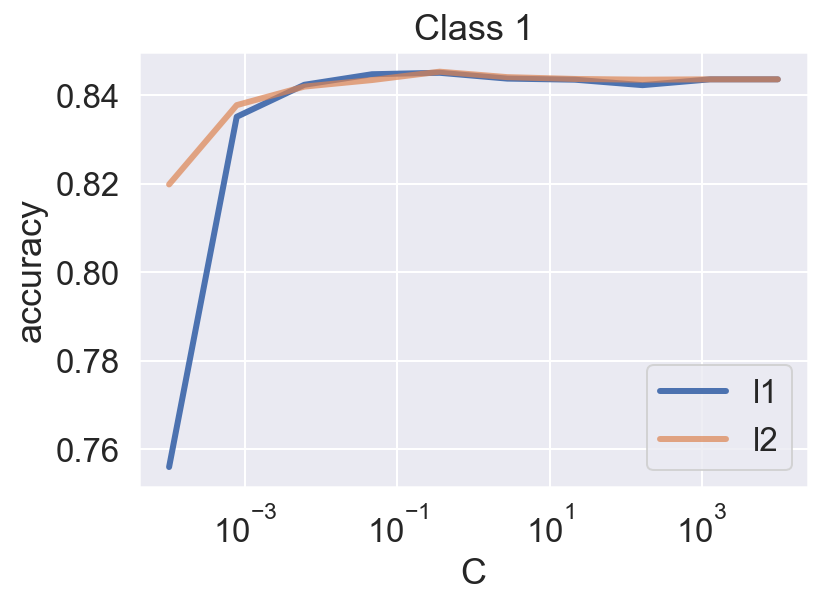

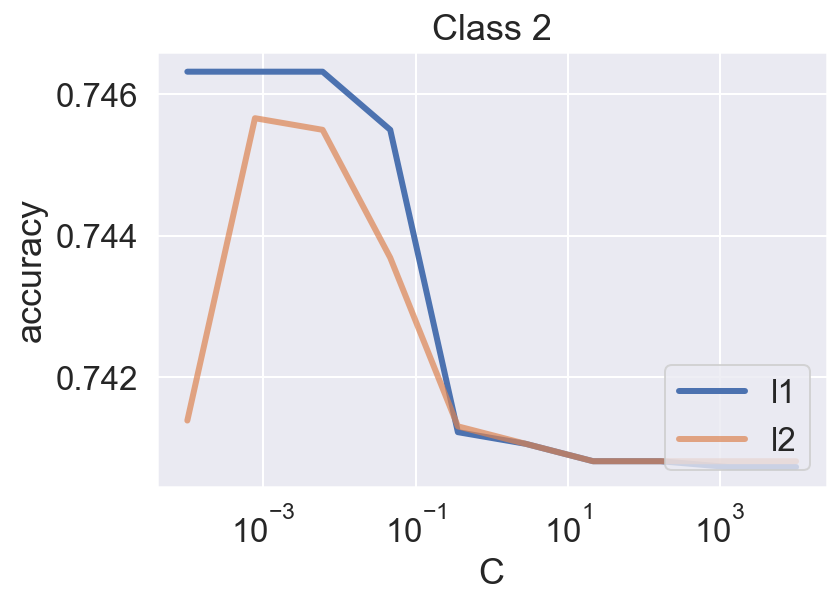

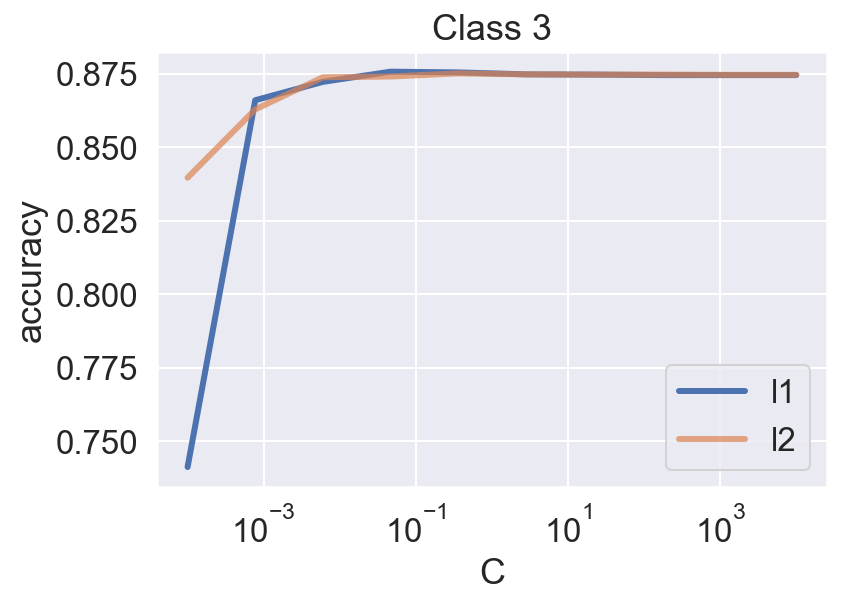

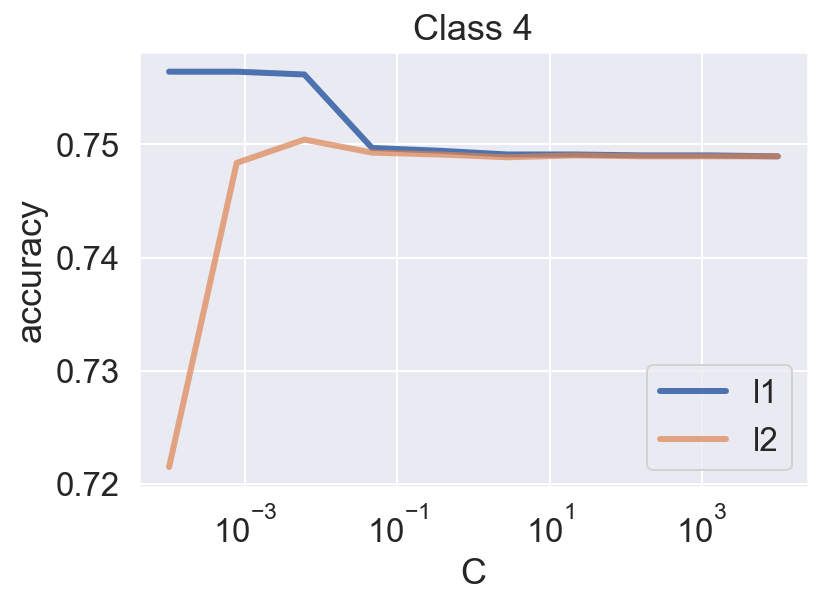

In [50]:
for i, cl in enumerate(model.classes_):
    plt.plot(model_l1.Cs_, list(model_l1.scores_.values())
             [i].mean(axis=0), lw=3, label='l1')
    plt.plot(model_l2.Cs_, list(model_l2.scores_.values())
             [i].mean(axis=0), lw=3, alpha=0.7, label='l2')
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.title('Class {}'.format(cl))
    plt.show()

### 12. Bonus: Create a ROC curve and a precision-recall curve for the best l1 and l2 models

In [51]:
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [52]:
y_test_bin = label_binarize(y_test, model_l1.classes_)

In [53]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

In [54]:
def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

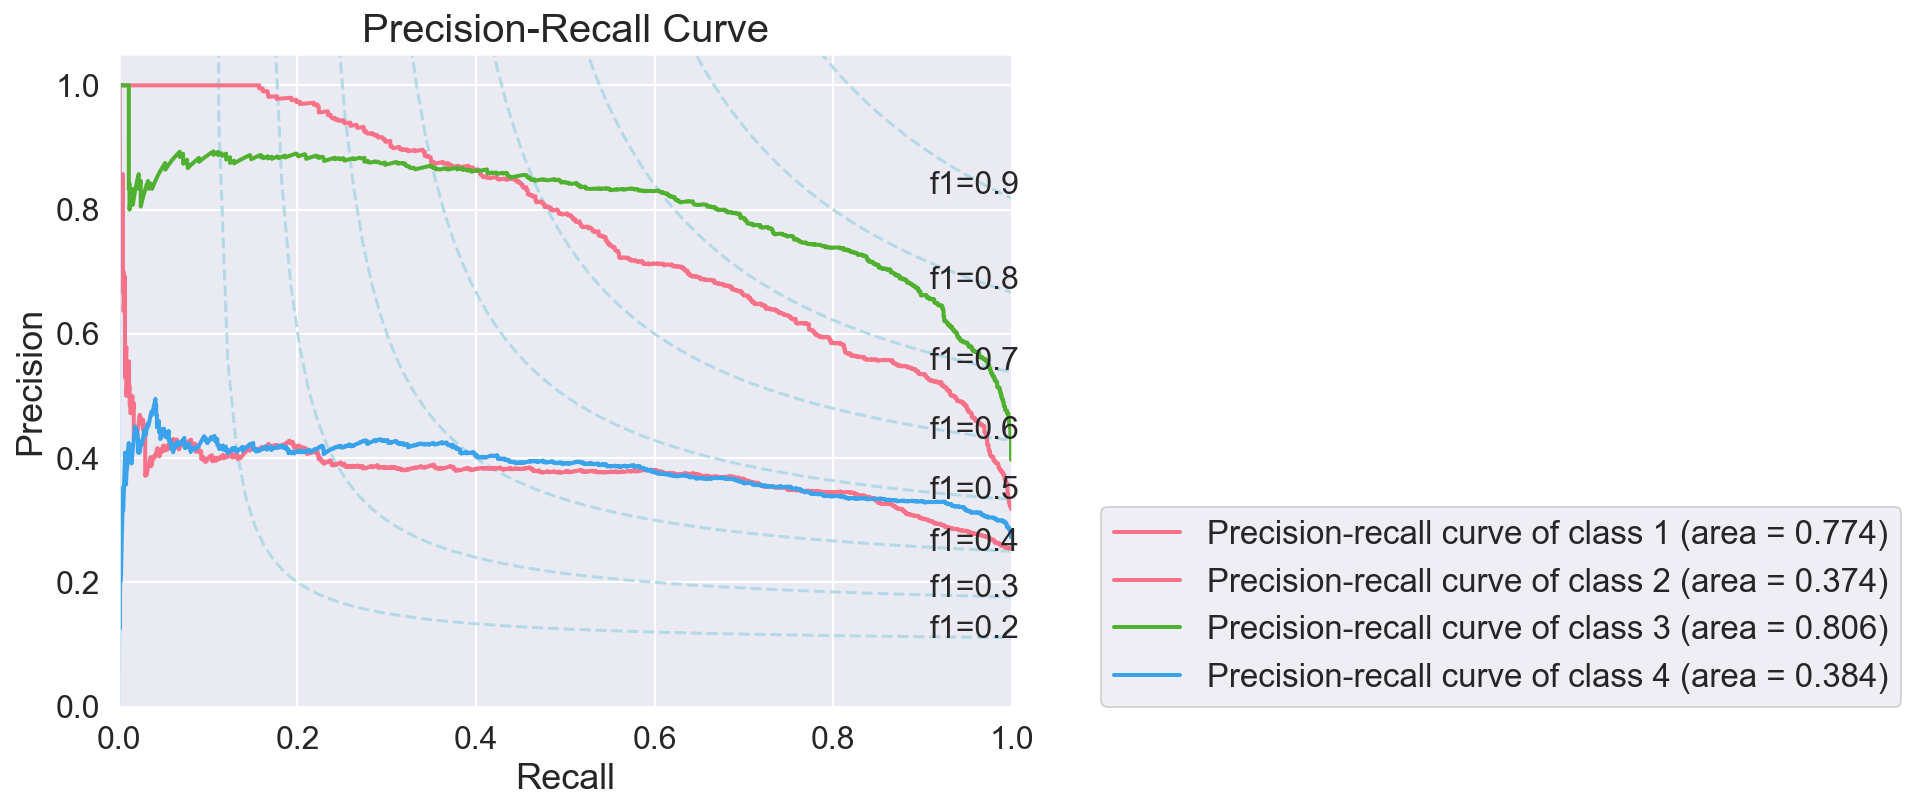

Area under precision-recall curve:
Class 1: 0.7738
Class 2: 0.3739
Class 3: 0.8056
Class 4: 0.3837


In [55]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, model_l1.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(model_l1.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin[:, i], model_l1.predict_proba(X_test)[:, i]), 4))

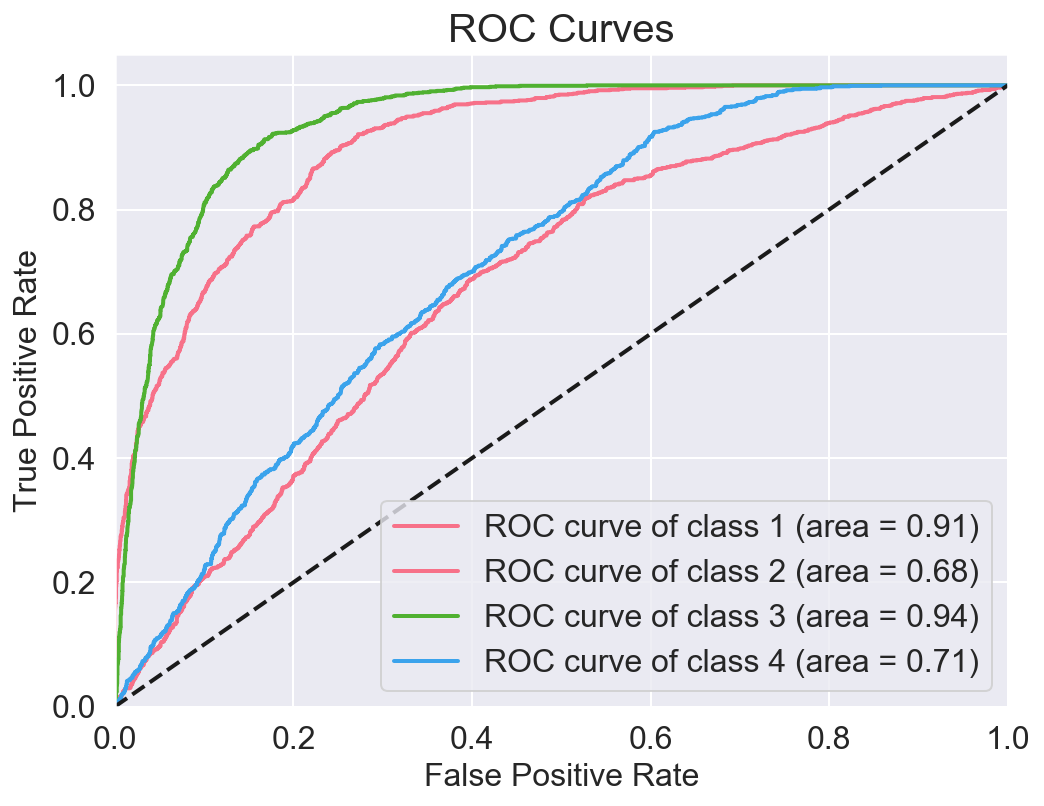

Area under ROC curve (ROC-AUC):
Class 1: 0.91
Class 2: 0.68
Class 3: 0.94
Class 4: 0.71


In [56]:
skplt.metrics.plot_roc(y_test, model_l1.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(model_l1.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin[:, i], model_l1.predict_proba(X_test)[:, i]), 2))

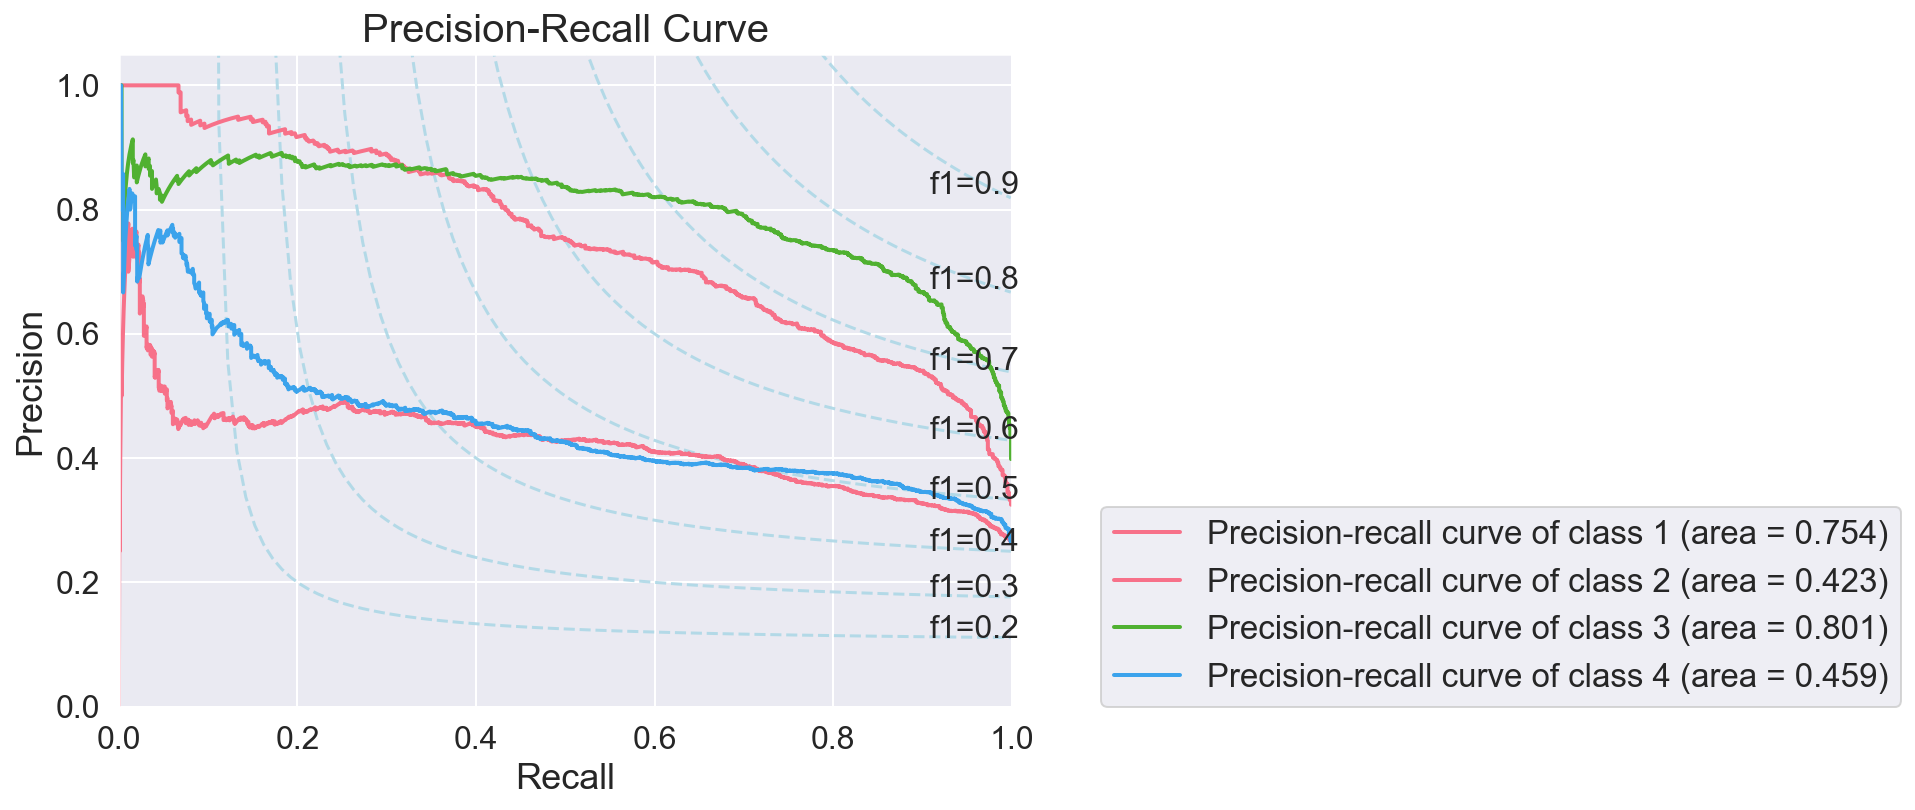

Area under precision-recall curve:
Class 1: 0.7536
Class 2: 0.4228
Class 3: 0.8006
Class 4: 0.4592


In [57]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, model_l2.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(model_l2.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin[:, i], model_l2.predict_proba(X_test)[:, i]), 4))

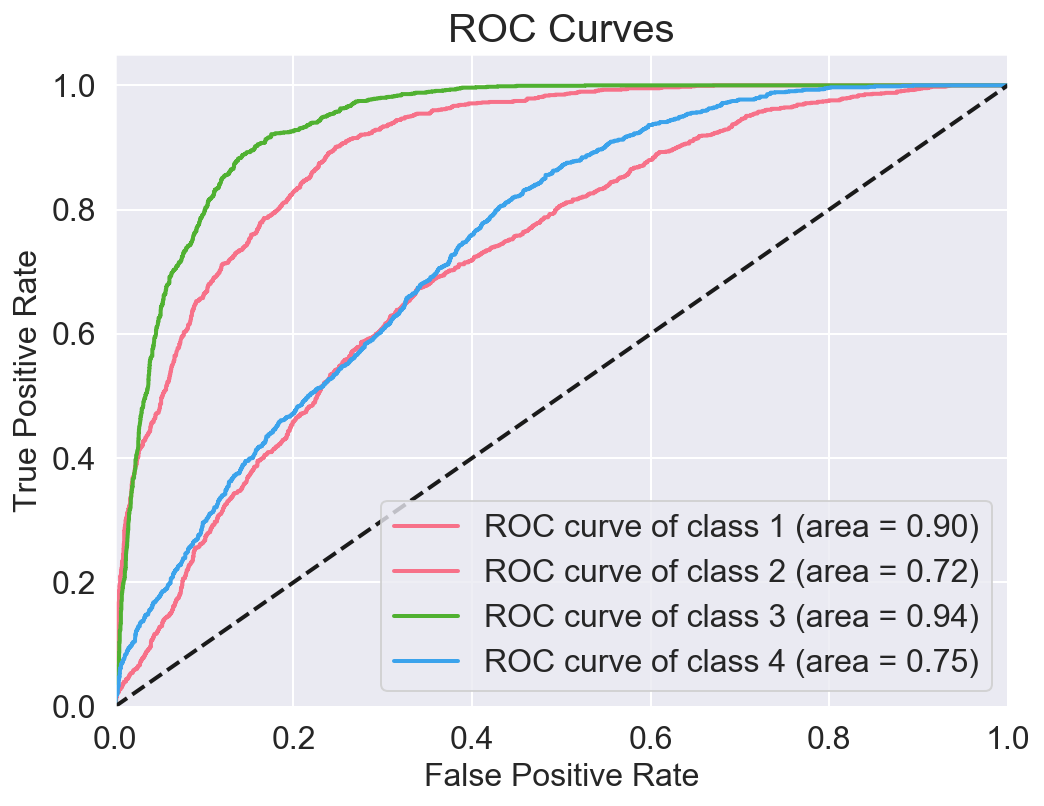

Area under ROC curve (ROC-AUC):
Class 1: 0.9
Class 2: 0.72
Class 3: 0.94
Class 4: 0.75


In [58]:
skplt.metrics.plot_roc(y_test, model_l2.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(model_l2.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin[:, i], model_l2.predict_proba(X_test)[:, i]), 2))